# <center>Supervised classification | K-Means</center>

We proceed to make a supervised classification of satelite images with the algorithm K-Means.

#  Index
The tutorial contains the following sections properly explain.

**1. Setup**

    1.1. Set up docker
    
    1.2. Importing libraries
    
    1.3. Downloading Sentinel-2 images
    
    
**2. Dataset processing**

    2.1. Load a raster image
    
    2.2. Obtain the pixels of the training areas
    
    2.3. Build the training for the classifier
    
    2.4. Train the model
    
    2.5. Prediction
    
    2.6. Export and import trained model 

# 1. Setup

### 1.1. Set up docker

To work with all the libraries in a **jupyter notebook** we will run a **docker** built for the experiment. It is necesarry to download <a href="https://www.docker.com/products/docker-desktop">docker desktop</a>, once it is done, we download and run the image of the docker that its gonna be used.

> docker pull mavsonnen/jupy-notebook:geosv2<br>
> docker run mavsonnen/jupy-notebook:geosv2

A **local directory** can be connected to a docker container creating a volume using <i>-v option</i>, change <i>local_path</i>:

> docker run -p 8888:8888 -v local_path:/home/jovyan/work mavsonnen/jupy-notebook:geosv2

### 1.2. Importing libraries

The following libraries are necessary:

In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from shapely.geometry import mapping
from IPython.display import Image
from IPython.core.display import HTML 
from shapely.geometry import mapping
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import lithops
import pandas
import pickle
import joblib
import time
import glob
import os
import io

print("Libraries imported succesfully")

Libraries imported succesfully


### 1.3. Downloading Sentinel-2 images

We will work with Sentinel-2 images with Level-2A, which already has an atmospheric correction. The data will be downloaded from **Copernicus Open Access Hub** in the following <a href="https://scihub.copernicus.eu/dhus/#/home">link</a>. 

Copernicus Open Access Hub offers us many searching options like sensing and ingestion period. It is important to work with Sentinel-2 level 2A satelite images, product type has to be set like  <i>S2MSl2A</i>.

Using the right click on the map we create the area of interest. As it is showed in the following image, Copernicus will show  all the raster images that overlap the area of interest allowing the user to view the details and choose which ones to **download**.

Every product from copernicus comes with a large amount of files and information. In every product it will be needed three **Surface Reflectance** (SRE) bands, the ones which end up in the form: "SRE_B2", "SRE_B3" and "SRE_B8".

![Image of Yaktocat](https://scihub.copernicus.eu/twiki/pub/SciHubUserGuide/GraphicalUserInterface/gui-10.jpg)

# 2. Dataset processing

### 2.1. Stackering bands

The aim of this section is to **stack all the selected bands** in a unique raster image for the future classification. We start defining the **directories** of the folder where the raster images downloaded are located.

In [2]:
tmp = '/home/jovyan/work/serverless/'
path = tmp + 'test/'

img_stack = path + 'output/raster_stackering.tif'

Based on the criteria we select all the bands for the stackering process.

In [3]:
criteria = 'SENTINEL*.tif'

input_directory = path + criteria
list_files = glob.glob(input_directory)
print(list_files)

['/home/jovyan/work/serverless/test/SENTINEL2B_20201101-110020-834_L2A_T30SXJ_C_V2-2_SRE_B3.tif', '/home/jovyan/work/serverless/test/SENTINEL2B_20201101-110020-834_L2A_T30SXJ_C_V2-2_SRE_B4.tif', '/home/jovyan/work/serverless/test/SENTINEL2B_20201101-110020-834_L2A_T30SXJ_C_V2-2_SRE_B8.tif']


We take the **metadata information** from one band and update it for later define it over the stacked raster image.

In [4]:
raster_meta = rasterio.open(list_files[0])
meta = raster_meta.meta 
meta.update(count = len(list_files))
meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32630),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 4400040.0)}

We process to **stack** the layers from the raster bands.

In [5]:
with rasterio.open(img_stack, 'w', **meta) as dst:
    for id, layer in enumerate(list_files, start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id, src1.read(1))
print('Stackering process finished successfully.')

Stackering process finished successfully.


Check the **dimensions, number of bands and show** the raster image composed by all bands.

The stakering image has the shape: (10980, 10980) and it is composed of 3 bands.


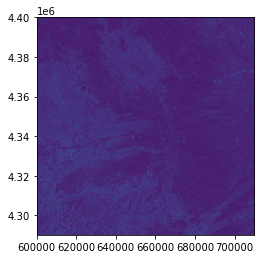

<AxesSubplot:>

In [6]:
full_data = rasterio.open(img_stack)
print('The stakering image has the shape: {} and it is composed of {} bands.'.format(full_data.shape,full_data.count))
show(full_data)

### 2.2. Obtain the pixels of the training areas

The raster is gonna be splitted in different areas for the future training of the classifier. For this step we need to **create an ERSI Shapefile** with different training polygons, the ones that are gonna be used for the training process. We can help from QGIS or SNAP software for creation of those areas.

![](https://community.hexagongeospatial.com/t5/image/serverpage/image-id/4240iF1A4D500227ABC21/image-size/original?v=1.0&px=-1)

Define the **directory** to the training areas shapefile.

In [7]:
name = 'valenciana_704000.0-4400000.0_comunidad_mask'
train_areas = gpd.read_file(f'{tmp}training/areas_{name}.shp')
print('The training area has the shape: {} with a coordinate reference system {}.'.format(train_areas.shape,train_areas.crs))

The training area has the shape: (155, 6) with a coordinate reference system epsg:32630.


<u>Note</u>: if it does not have the same coordinate system of the dataset use to_crs and set the correct epsg. Now we generate a list of geometries and check a random feature to verify.

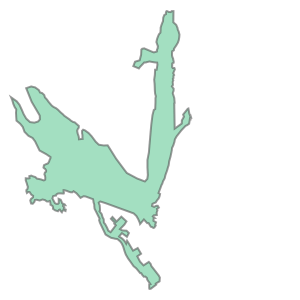

In [8]:
geoms = train_areas.geometry.values
geometry = geoms[0]
geoms[10]

The **raster values are extracted** within the training areas

In [9]:
img_stack = tmp + 'tiling/' + name +'.tif'
full_data = rasterio.open(img_stack)

In [10]:
feature = [mapping(geometry)]
out_img_extr, out_transform = mask(full_data, feature, crop=True)
out_transform

Affine(10.0, 0.0, 704000.0,
       0.0, -10.0, 4386400.0)

### 2.3. Build the training for the classifier

Based on the previous data we have been analysing, we create two arrays with the **feature and labels data** for the training of the classifier. First we define two empty arrays:

In [11]:
X = np.array([], dtype=np.int8).reshape(0,3) # pixels
y = np.array([], dtype=np.string_) # labels

**Extract the value** of our raster within the training polygons. We get <i>X</i> and <i>y</i>, the features and layers arrays respectively.

In [12]:
with rasterio.open(img_stack) as src:
    band_count = src.count
    
    for index, geom in enumerate(geoms):      
        feature = [mapping(geom)] # transform to gjson format for an easier manipulation.      
        out_img_extr, out_transform = mask(src, feature, crop=True) # mask return pixel in to array    
        out_img_extr_trimmed = out_img_extr[:,~np.all(out_img_extr == 0, axis=0)] # remove all pixels with 0 values 
        out_img_extr_trimmed = out_img_extr_trimmed[:,~np.all(out_img_extr_trimmed == 255, axis=0)] # remove all pixels with 255 values  
        out_img_extr_reshaped = out_img_extr_trimmed.reshape(-1, band_count) # reshape the array
        
        y = np.append(y,[train_areas["layer"][index]] * out_img_extr_reshaped.shape[0]) # add the labels to array
        X = np.vstack((X,out_img_extr_reshaped)) # stack the pixels to array

print('We define X as the array that stores the features with a shape {} and y as the labels array with a shape {}.'.format(X.shape,y.shape))        

We define X as the array that stores the features with a shape (1994332, 3) and y as the labels array with a shape (1994332,).


**Check the different classes** that are define in our raster image.

In [13]:
print('The raster image contain {} classes which are the following: \n {}'.format(np.unique(train_areas["layer"]).size, np.unique(train_areas["layer"])))

The raster image contain 5 classes which are the following: 
 ['matorral_boscoso_de_transicion' 'pastizales_naturales'
 'superficie_artificial' 'vegetacion_esclerofila' 'zonas_agricolas']


### 2.4.Train the model


Once all the data have been proccess we are ready to **train the classifier**, in this section the classifier will learn from our data in order to make an accurate classification for the next raster image to be classified.

In [14]:
gnb = GaussianNB()
gnb.fit(X, y)
print("Naive Bayes trainned.")

Naive Bayes trainned.


In order to achieve a better classification the model have to be **train with more raster images**. The dataset used to train the model have to be diverse and paying attention not to fall in overfiting or underfitting.

### 2.5. Prediction 

We proceed to make the prediction, however it is gonna be done with serverless technology in the following sections so migth skip this point 2.5.

We advance to the **prediction of the raster**. Based on what the classifier has learn it will make a classification with a maximun of 10 different classes, the ones are shown bellow.

- artificial surface
- water surface
- transition vegetation
- conifers
- hardwood forest
- natural grasslands
- mediterranean scrub
- dry farming land
- agricultural areas
- wetlands
- burned areas

It is defined a function <i>str_class_to_int</i> that assigns the classes to indices and some modification of the raster shape to be able to perform the prediction.

In [15]:
def str_class_to_int(class_array):
    class_array[class_array == 'superficie_artificial'] = 1
    class_array[class_array == 'bosque_de_coniferas'] = 2
    class_array[class_array == 'bosque_de_frondosas'] = 3
    class_array[class_array == 'zonas_agricolas'] = 4
    class_array[class_array == 'vegetacion_esclerofila'] = 5
    class_array[class_array == 'pastizales_naturales'] = 6
    class_array[class_array == 'matorral_boscoso_de_transicion'] = 7
    class_array[class_array == 'zonas_quedamas'] = 8
    class_array[class_array == 'zonas_humedas'] = 9
    class_array[class_array == 'superficie_agua'] = 10
    return(class_array.astype(int))

If the computing cost is making the process significantly slower, if it is necessary to work with a part of the image, in that case don't read the whole image defining the **position**: col_off, row_off, width, height. For <u>example</u>: <i>src.read()[:, 1500: 2000, 1500 : 2500]</i>.

In [16]:
with rasterio.open(img_stack) as src:
    img = src.read()[:, : , :]

**Reshape** the complete image and in a long 2d matrix to be able to visualize it

In [17]:
reshaped_img = reshape_as_image(img)

For each pixel of our we **perform a prediction** and reshape our classified image in a 2d matrix to be able to see it

In [18]:
prediction = gnb.predict(reshaped_img.reshape(-1, 3))
prediction = prediction.reshape(reshaped_img[:, :, 0].shape)

From the shapefile initially convert the **strings to numpy matrix**.

In [19]:
prediction = str_class_to_int(prediction)
print(np.unique(prediction))
print(prediction.shape)

[1 4 5 6]
(1599, 1599)


**Show prediction** to have an overview of the raster classified.

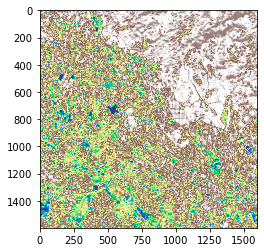

<AxesSubplot:>

In [20]:
show(prediction, cmap='terrain')

We can **save** the array as a raster image .tif which is the classified image. First we change the format to <i>int32</i> and then create an output raster image from the prediction.

In [21]:
y = prediction.astype(np.int32) 

SalidaR = rasterio.open(tmp + 'out3.tif','w',
                   driver='Gtiff',
                   width = 1599,
                   height = 1599,
                   count=1,
                   crs = full_data.crs,  
                   transform = full_data.transform, 
                   dtype='int32')
SalidaR.write(y,1)
SalidaR.close()

print("Raster image succesfully created!")

Raster image succesfully created!


### 2.6. Export and import  trained model 

Save the **Machine Learning model** based in Naive Bayes through <i>joblib</i> and import it. By doing so we will be able to upload it to IBM_COS. 


In [22]:
model = gnb
name_model = 'naive_bayes_model.sav' 
joblib.dump(model, tmp + '/COS/' + name_model)

print("Trained model saved")

Trained model saved


In [23]:
loaded_model = joblib.load(tmp + '/COS/' + name_model)

print("Train model imported")

Train model imported
